# xtream AI Engineer Assignment - Challenge 1

## 1. Introduction

In this notebook I will develop a model for predicting the price of diamonds, based on the provided dataset. But before digging into the model, I will perform an exploratory data analysis (EDA) to get some preliminary insights and take actions to clean the data.

## 2. EDA and data cleansing

For this very important, first step I will start loading the data and doing some very preliminary EDA with a few `pandas` commands.

In [1]:
import pandas as pd

# Load data
data_original = pd.read_csv('../datasets/diamonds/diamonds.csv')

In [2]:
data_original.head()

carat        cut color clarity  depth  table  price     x     y     z
0   1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1   1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2   1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3   1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4   0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82

In [3]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


There are three categorical features (*cut*, *color*, and *clarity*). To my understanding, the three of them are ordered and thus I will use an ordinal encoder to convert them to numerical features.

In [4]:
from sklearn.preprocessing import OrdinalEncoder

data_encoded = data_original.copy()

enc = OrdinalEncoder(categories=[['Fair','Good','Very Good','Ideal','Premium']])
X = data_original['cut'].values.reshape(-1, 1)
data_encoded['cut'] = enc.fit_transform(X).astype(int)

enc = OrdinalEncoder(categories=[list(map(chr, range(ord('D'), ord('Z')+1)))])
X = data_original['color'].values.reshape(-1, 1)
data_encoded['color'] = enc.fit_transform(X).astype(int)

enc = OrdinalEncoder(categories=[['I1','SI2','SI1','VS2','VS1','VVS2','VVS1',
                                  'IF']])
X = data_original['clarity'].values.reshape(-1, 1)
data_encoded['clarity'] = enc.fit_transform(X).astype(int)

I could could continue using pandas and matplotlib (or seaborn or plotly). But, rather, I will use the library `ydata profiling` (formerly known as `pandas profiling`), which is an easy-to-use and comprehensive EDA tool.

In [13]:
from ydata_profiling import ProfileReport

# The package ydata profiling presents the interactions as either scatter plots
# or hexbin plots. I find the scatter plots more informative. But, due to the
# underlying plot tool being used, the report becomes too heavy when scatter
# plots of more than 1000 points are generated. Thus, it is possible to set a
# number of points threshold above which these plots are presented as hexbin
# instead of scatter. Here I left this threshold (scatter_threshold) in its
# default value in order to make the notebook light. Setting it to a number
# above 5000 will show scatter interaction plots.

data_encoded.profile_report(title='Diamonds EDA Report', progress_bar=False,
                            # Distinct values to consider a feature as
                            # categorical (default=5)
                            vars={'num': {'low_categorical_threshold': 4}},
                            # Number of points to plot interactions as hexbin
                            # instead of scatter (default=1000)
                            plot={'scatter_threshold': 1000})

EDA remarks and actions:

- There is one pair of duplicate rows in the dataset (see 'Duplicate rows' in the report). I believe this could be related to the large number of diamonds in the dataset and the precision in the measurements of each diamond feature (for example, it could be possible that two diamonds are almost identical in every feature except the *carat*, but the difference is below the measurement precision or the real values were rounded before including them in the dataset). Therefore, I think they could genuinely be two different specimens and I will keep the two rows.

- There are ten dataset observations with negative prices (see the summary for *price* in the report). I could try to do some imputation for those values, but since the price is what I want to predict and these entries represent only 0,2% of the data, I will drop them.

In [6]:
data_clean = data_encoded.copy()
data_clean = data_clean[data_clean['price']>0]

- The features *x*, *y*, and *z* have one zero value, each. Actually, this is explained by just one observation in the dataset (see next cell). These three features seem to have influence in the price (see 'Interactions' in the report). They show some correlation with each other but they are not correlated with other features (see 'Correlations' in the report). I think an imputation here would not be useful and given it is only one observation, I will drop it.

In [7]:
data_encoded[data_encoded['x']==0]

carat  cut  color  clarity  depth  table  price    x    y    z
4321   2.25    4      4        1   62.8   59.0  18034  0.0  0.0  0.0

In [8]:
data_clean = data_clean[data_clean['x']!=0]

- The strongest correlations appear between pairs of dimensions *x*, *y*, *z* and between each of them with *carat*. The correlations between pairs of *x*, *y*, *z* translate to interactions that appear to be linear. This is not exactly the same for the interactions between *carat* with one of the former variables, in which cases the interactions tend to flatten out at the higher values of those features.

- The *price* is highly correlated with *carat* and with *x*, *y*, *z*. The interaction of *price* with each of those features doesn't look linear, but rather exponential.

- It is worth noting that *depth* and *table* despite depending mathematically from *z* and *x*, respectively, don't show any significative correlation with other features nor the *price*. I will keep those two features in the data because they may add some detail to the model.

- Given the remarks about correlations and interactions, to avoid redundancies, I will drop the features *x* and *y* (which are strongly correlated and have a linear interaction). Note: instead of just dropping features I could do some "feature engineering" (for example, through principal component analysis), but my idea is to try and get an interpretable model, so I prefer to keep the original variables, which they have a clear meaning.

In [9]:
data_clean = data_clean.drop(columns=['x','y'])

- As a side note, the value distribution of *z* (also *x* and *y*) appear to be bimodal. I don't know the reason and don't expect this to negatively affect the model.

As a last step in the EDA, I will perform a quick search for outliers (or anomalies). There are several possibilities for doing this. Here I chose a method based in the calculation of the distance of a data point to the median absolute deviation (MAD) of the data distribution. I will use the following function (for univariate outliers):

In [10]:
# Function to flag outliers based on the MAD for an asymmetric distribution
# Source: https://stackoverflow.com/a/29222992
# Based on: https://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/

import numpy as np

def doubleMADsfromMedian(y, thresh=3.5):
    """ Warning: this function does not check for NAs
    nor does it address issues when 
    more than 50% of your data have identical values"""
    
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad # z-score using MAD
    modified_z_score[y == m] = 0

    return modified_z_score > thresh

As an example, I'll compute individually the outliers of the feature *carat* and the *price*. Then I'll show a scatter plot of *price* vs *carat* marking with a different color the possible outliers (either from *carat* or *price*).

In [11]:
outliers_carat = doubleMADsfromMedian(data_clean['carat'])
outliers_price = doubleMADsfromMedian(data_clean['price'])
outliers_2D = outliers_carat | outliers_price # Either a carat or price outlier
print(f"There are {outliers_2D.sum()} possible outliers.")

There are 45 possible outliers.


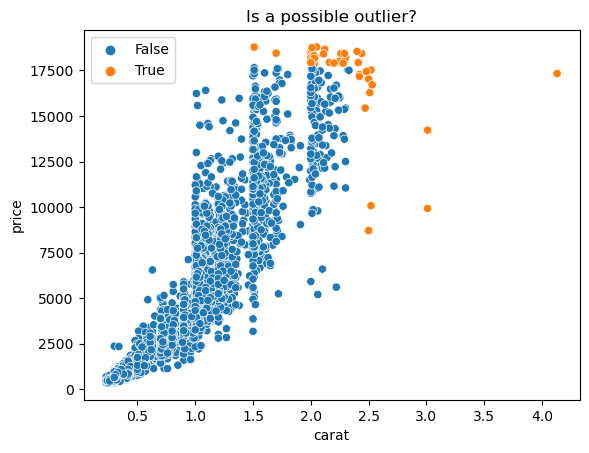

In [12]:
import seaborn as sns

ax = sns.scatterplot(data=data_clean, x='carat', y='price', hue=outliers_2D)
ax.set(title='Is a possible outlier?');

Outlier handling is a tricky business since it is plausible that the flagged observations correspond to real specimens and not some sort of data collection/processing anomaly. In this case, I believe they can be considered a genuine part of the population of interest and due to their quantity and quality may not have a significant influence in the model. This actually can be tested once the model is available, rendering the so-called *influential observations*. But, for the sake of time, I will not further dig in the outlier subject for this challenge.

## 3. Model development

Model development.